In [10]:
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")

# load datasets
users_features = pd.read_csv("data/Social_spammers_dataset/users_features/features.csv")
labels = pd.read_csv("data/Social_spammers_dataset/users/coded_ids_labels_train.csv")
code_ids_label = pd.read_csv("data/Social_spammers_dataset/users/coded_ids.csv")
test_submission = pd.read_csv("data/Social_spammers_dataset/users/coded_ids_labels_test.csv")
users_features = pd.merge(users_features, code_ids_label, on='user_id')

In [11]:
# merge features and tarin label
users_features_with_labels = pd.merge(users_features, labels, on='coded_id')
users_features.head()

,active_tweeting_frequency_per_day,adjusted_nb_of_uses_of_hashtag,adjusted_nb_of_uses_of_mention,adjusted_nb_of_uses_of_sources,adjusted_nb_of_uses_of_url,age,avg_intertweet_times,avg_intertweet_times_seconds,content_duration_days,date_newest_tweet,...,time_since_newest_tweet_months,time_zone,tweeting_frequency_per_day,tweets_with_at_top_20,tweets_with_hashtags_top_20,tweets_with_urls_top_20,urls_used_on_average,user_id,utc_offset,coded_id
0,0.055,2.600,5.308,21.087,2.333,2186,19 days 05:12:37.409091000,1660357.0,422,26/12/2017 14:45:25,...,1.533333,Hawaii,5.396,10,5,5,2.000,494199648,-36000.0,203
1,154.333,3.447,13.164,463.000,1.045,1286,0 days 00:10:33.400433000,633.0,3,27/12/2014 22:46:34,...,38.033333,NaN,11.567,13,6,1,1.023,2708449765,NaN,112
2,40.000,9.938,8.329,400.000,1.000,2474,0 days 00:39:20.897243000,2361.0,10,10/02/2018 17:00:37,...,0.000000,Riyadh,35.167,19,2,1,1.000,293270197,10800.0,138
3,0.334,2.600,2.412,55.284,36.885,3220,16 days 16:04:30.509317000,1440271.0,485,04/07/2011 03:37:09,...,80.466667,Pacific Time (US & Canada),0.051,0,0,20,2.400,33046208,-28800.0,148
4,4.494,0.000,0.000,203.380,1.000,816,0 days 05:24:08.857143000,19449.0,89,09/02/2018 12:43:09,...,0.033333,Pacific Time (US & Canada),23.863,0,0,20,1.000,4217668515,-28800.0,182


# Exploration of data

In [12]:
# informations about data 
users_features_with_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 686 entries, 0 to 685
Columns: 147 entries, active_tweeting_frequency_per_day to label
dtypes: bool(2), float64(93), int64(44), object(8)
memory usage: 783.8+ KB


In [13]:
# total null values
users_features_with_labels.isna().sum().sum()

1022

spam_in_screen_name
686
time_zone
168
utc_offset
168


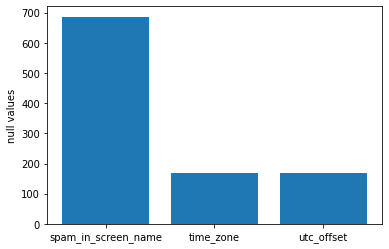

<Figure size 432x288 with 0 Axes>

In [14]:
# number of null values in columns
import matplotlib.pyplot as plt

#######################################################################
columns = list(users_features_with_labels.iloc[0:0,])
x=[]
y=[]
for col in columns :
    s = users_features_with_labels[col].isna().sum()
    if (s != 0):
        print (col)
        x.append(col)
        print(s)
        y.append(s)
    else:
        pass
#########################################################################

plt.bar(x,y,align='center') # A bar chart
plt.ylabel('null values')
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig("null_values.png", dpi=100)

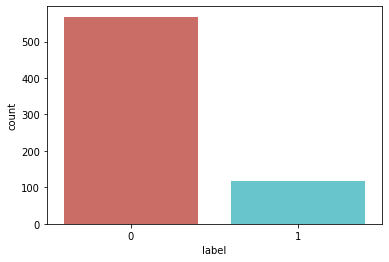

In [15]:
# we have unbalanced data
import seaborn as sb  
%matplotlib inline  
users = users_features_with_labels
sb_label = sb.countplot(x='label', data = users, palette = 'hls')
sb_label
sb_label.figure.savefig("label.png")

In [16]:
# how column influence in detection of spammers
def explore_column (name_column):
    sb_to20 = sb.catplot(y=name_column, x= 'label', kind="bar" ,data = users)
    sb_to20
    sb_to20.savefig(name_column+".png")

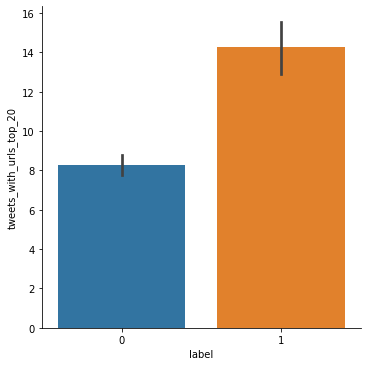

In [17]:
# how column tweets_with_urls_top_20 influence in detection of spammers
explore_column ('tweets_with_urls_top_20')

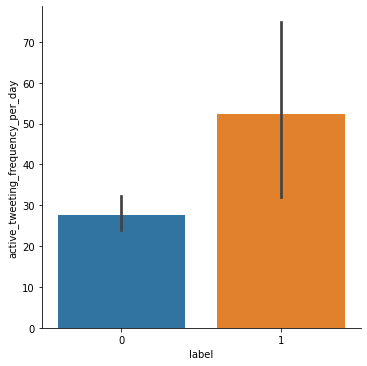

In [18]:
explore_column ('active_tweeting_frequency_per_day')

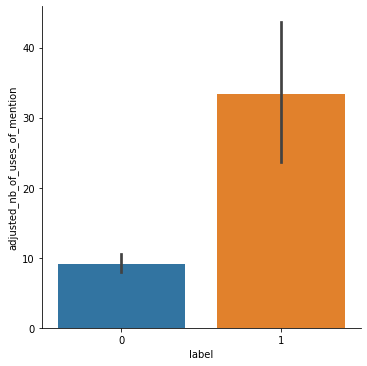

In [19]:
explore_column ('adjusted_nb_of_uses_of_mention')

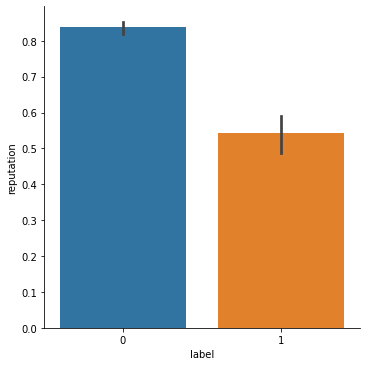

In [20]:
explore_column ('reputation')

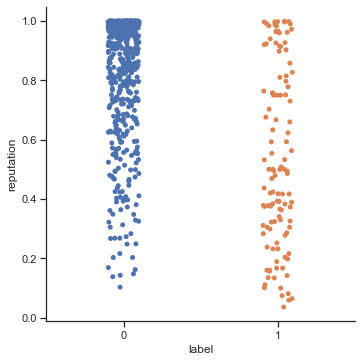

In [21]:
# reputation destribution
sb.set_theme(style="ticks")
sb.catplot(y="reputation", x="label", data=users)

## Features extraction

In [17]:
## all values of column spam_in_screen_name are null
users_features_with_labels['spam_in_screen_name'] 

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
681   NaN
682   NaN
683   NaN
684   NaN
685   NaN
Name: spam_in_screen_name, Length: 686, dtype: float64

In [18]:
#so we can delete this column spam_in_screen_name
users = users_features_with_labels.drop(['spam_in_screen_name'], axis=1)

In [19]:
'''Frequent Category Imputation
This technique is used to fill the missing values in categorical data. 
In this, we replace NaN values with the most Frequent label. 
First, we find the most frequent label and then replace NaN with it.'''

def impute_nan(df,variable):
    most_frequent_category=df[variable].mode()[0] ##Most Frequent
    df[variable].fillna(most_frequent_category,inplace=True) 
    
for feature in ['time_zone']:           ##List of Categorical Features
    impute_nan(users,feature)

for feature in ['utc_offset']:           ##List of Categorical Features
    impute_nan(users,feature)

users[['time_zone','utc_offset']].head(8)

,time_zone,utc_offset
0,Hawaii,-36000.0
1,Riyadh,10800.0
2,Pacific Time (US & Canada),-28800.0
3,Pacific Time (US & Canada),-28800.0
4,Central Time (US & Canada),-21600.0
5,Pacific Time (US & Canada),-28800.0
6,Riyadh,10800.0
7,Eastern Time (US & Canada),-14400.0


In [51]:
# types of columns
columns = list(users.iloc[0:0,])
float_columns = []
int_columns = []
boolean_columns = []
else_columns = []
object_columns = []
for i in columns :
    #print (users[i].head(5))
    if users[i].dtype == 'float64':
        float_columns.append(i)
        #print (users[i].dtype)
    if users[i].dtype == 'int64':
        int_columns.append(i)
        #print (users[i].dtype)
    if users[i].dtype == 'bool':
        boolean_columns.append(i)
        #print (users[i].dtype)
    if users[i].dtype == 'object':
        object_columns.append(i)
        #print (users[i].dtype)
    else :
        else_columns.append(i)
        #print (users[i].dtype)

In [21]:
# columns contain objects values
users[object_columns].head()

,avg_intertweet_times,date_newest_tweet,date_oldest_tweet,lang,max_intertweet_times,min_intertweet_times,std_intertweet_times,time_zone
0,19 days 05:12:37.409091000,26/12/2017 14:45:25,29/10/2016 20:07:42,ar,176 days 23:35:57.000000000,0 days 00:00:08.000000000,47 days 07:09:24.508885000,Hawaii
1,0 days 00:39:20.897243000,10/02/2018 17:00:37,30/01/2018 19:20:39,en,1 days 18:22:38.000000000,0 days 00:00:02.000000000,0 days 02:52:56.811122000,Riyadh
2,16 days 16:04:30.509317000,04/07/2011 03:37:09,05/03/2010 06:21:35,en,673 days 21:00:01.000000000,0 days 00:00:07.000000000,58 days 12:50:08.084253000,Pacific Time (US & Canada)
3,0 days 05:24:08.857143000,09/02/2018 12:43:09,11/11/2017 17:08:15,ar,9 days 05:21:55.000000000,0 days 00:00:00.000000000,0 days 21:07:19.150078000,Pacific Time (US & Canada)
4,0 days 00:19:59.997494000,10/02/2018 17:15:00,05/02/2018 04:15:01,en,0 days 02:00:01.000000000,0 days 00:00:00.000000000,0 days 00:21:00.323079000,Central Time (US & Canada)


In [22]:
# columns contain boolean values
users[boolean_columns].head()

,default_profile,default_profile_image
0,False,False
1,False,False
2,True,False
3,True,False
4,True,False


In [23]:
# function for delete columns
def delete_columns (data,liste_columns) :
    return(data.drop(liste_columns, axis=1))

# we delete 'user_id','coded_id','utc_offset' because its not influence in spam detection
users=delete_columns(users,['user_id','coded_id','utc_offset'])  
users.head()

,active_tweeting_frequency_per_day,adjusted_nb_of_uses_of_hashtag,adjusted_nb_of_uses_of_mention,adjusted_nb_of_uses_of_sources,adjusted_nb_of_uses_of_url,age,avg_intertweet_times,avg_intertweet_times_seconds,content_duration_days,date_newest_tweet,...,temporal_bin_7,time_since_newest_tweet_days,time_since_newest_tweet_months,time_zone,tweeting_frequency_per_day,tweets_with_at_top_20,tweets_with_hashtags_top_20,tweets_with_urls_top_20,urls_used_on_average,label
0,0.055,2.600,5.308,21.087,2.333,2186,19 days 05:12:37.409091000,1660357.0,422,26/12/2017 14:45:25,...,0.043,46,1.533333,Hawaii,5.396,10,5,5,2.000,0
1,40.000,9.938,8.329,400.000,1.000,2474,0 days 00:39:20.897243000,2361.0,10,10/02/2018 17:00:37,...,0.117,0,0.000000,Riyadh,35.167,19,2,1,1.000,0
2,0.334,2.600,2.412,55.284,36.885,3220,16 days 16:04:30.509317000,1440271.0,485,04/07/2011 03:37:09,...,0.167,2414,80.466667,Pacific Time (US & Canada),0.051,0,0,20,2.400,1
3,4.494,0.000,0.000,203.380,1.000,816,0 days 05:24:08.857143000,19449.0,89,09/02/2018 12:43:09,...,0.000,1,0.033333,Pacific Time (US & Canada),23.863,0,0,20,1.000,1
4,80.000,395.000,0.000,400.000,174.673,1174,0 days 00:19:59.997494000,1200.0,5,10/02/2018 17:15:00,...,0.110,0,0.000000,Central Time (US & Canada),46.056,0,19,20,1.908,1


In [24]:
# features
X = users.iloc[:,0:142]
X

,active_tweeting_frequency_per_day,adjusted_nb_of_uses_of_hashtag,adjusted_nb_of_uses_of_mention,adjusted_nb_of_uses_of_sources,adjusted_nb_of_uses_of_url,age,avg_intertweet_times,avg_intertweet_times_seconds,content_duration_days,date_newest_tweet,...,temporal_bin_6,temporal_bin_7,time_since_newest_tweet_days,time_since_newest_tweet_months,time_zone,tweeting_frequency_per_day,tweets_with_at_top_20,tweets_with_hashtags_top_20,tweets_with_urls_top_20,urls_used_on_average
0,0.055,2.600,5.308,21.087,2.333,2186,19 days 05:12:37.409091000,1660357.0,422,26/12/2017 14:45:25,...,0.261,0.043,46,1.533333,Hawaii,5.396,10,5,5,2.000
1,40.000,9.938,8.329,400.000,1.000,2474,0 days 00:39:20.897243000,2361.0,10,10/02/2018 17:00:37,...,0.362,0.117,0,0.000000,Riyadh,35.167,19,2,1,1.000
2,0.334,2.600,2.412,55.284,36.885,3220,16 days 16:04:30.509317000,1440271.0,485,04/07/2011 03:37:09,...,0.080,0.167,2414,80.466667,Pacific Time (US & Canada),0.051,0,0,20,2.400
3,4.494,0.000,0.000,203.380,1.000,816,0 days 05:24:08.857143000,19449.0,89,09/02/2018 12:43:09,...,0.072,0.000,1,0.033333,Pacific Time (US & Canada),23.863,0,0,20,1.000
4,80.000,395.000,0.000,400.000,174.673,1174,0 days 00:19:59.997494000,1200.0,5,10/02/2018 17:15:00,...,0.115,0.110,0,0.000000,Central Time (US & Canada),46.056,0,19,20,1.908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,0.995,1.000,2.256,163.250,1.013,2738,1 days 00:19:44.788945000,87585.0,201,25/10/2017 01:47:41,...,0.000,0.000,2,0.066667,Seoul,1.440,6,0,15,1.006
682,100.000,42.436,35.122,98.490,1.000,3405,0 days 00:14:56.216080000,896.0,2,25/10/2017 02:22:04,...,0.000,0.000,2,0.066667,Eastern Time (US & Canada),23.174,20,19,1,1.000
683,2.020,0.000,0.000,136.000,1.000,2249,0 days 11:56:53.567839000,43014.0,99,25/10/2017 02:45:34,...,0.005,0.005,2,0.066667,Tokyo,2.512,0,0,11,1.000
684,1.418,1.912,5.804,147.610,1.077,3137,0 days 17:06:45.271357000,61605.0,141,24/10/2017 05:27:02,...,0.050,0.180,3,0.100000,London,7.198,19,8,6,1.040


In [25]:
# types of columns
columns = list(X.iloc[0:0,])
float_columns = []
int_columns = []
boolean_columns = []
else_columns = []
object_columns = []
for i in columns :
    print (X[i].head(5))
    if X[i].dtype == 'float64':
        float_columns.append(i)
        print (X[i].dtype)
    if X[i].dtype == 'int64':
        int_columns.append(i)
        print (X[i].dtype)
    if X[i].dtype == 'bool':
        boolean_columns.append(i)
        print (X[i].dtype)
    if X[i].dtype == 'object':
        object_columns.append(i)
        print (X[i].dtype)
    else :
        else_columns.append(i)
        print (X[i].dtype)

0     0.055
1    40.000
2     0.334
3     4.494
4    80.000
Name: active_tweeting_frequency_per_day, dtype: float64
float64
float64
0      2.600
1      9.938
2      2.600
3      0.000
4    395.000
Name: adjusted_nb_of_uses_of_hashtag, dtype: float64
float64
float64
0    5.308
1    8.329
2    2.412
3    0.000
4    0.000
Name: adjusted_nb_of_uses_of_mention, dtype: float64
float64
float64
0     21.087
1    400.000
2     55.284
3    203.380
4    400.000
Name: adjusted_nb_of_uses_of_sources, dtype: float64
float64
float64
0      2.333
1      1.000
2     36.885
3      1.000
4    174.673
Name: adjusted_nb_of_uses_of_url, dtype: float64
float64
float64
0    2186
1    2474
2    3220
3     816
4    1174
Name: age, dtype: int64
int64
int64
0    19 days 05:12:37.409091000
1     0 days 00:39:20.897243000
2    16 days 16:04:30.509317000
3     0 days 05:24:08.857143000
4     0 days 00:19:59.997494000
Name: avg_intertweet_times, dtype: object
object
0    1660357.0
1       2361.0
2    1440271.0
3     

Name: std_nb_symbols_per_tweet, dtype: float64
float64
float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: std_nb_symbols_per_word_in_the_tweet, dtype: float64
float64
float64
0    0.439109
1    0.339034
2    0.312080
3    0.000000
4    0.282566
Name: std_nb_urls_per_tweet, dtype: float64
float64
float64
0    0.039
1    0.028
2    0.058
3    0.020
4    0.028
Name: std_nb_urls_per_word_in_the_tweet, dtype: float64
float64
float64
0    5.114936
1    8.286554
2    4.215231
3    3.327597
4    3.113237
Name: std_nb_words_per_tweet, dtype: float64
float64
float64
0    0.000
1    0.020
2    0.142
3    0.000
4    0.128
Name: temporal_bin_0, dtype: float64
float64
float64
0    0.000
1    0.052
2    0.142
3    0.000
4    0.133
Name: temporal_bin_1, dtype: float64
float64
float64
0    0.087
1    0.020
2    0.204
3    0.302
4    0.098
Name: temporal_bin_2, dtype: float64
float64
float64
0    0.000
1    0.077
2    0.099
3    0.228
4    0.168
Name: temporal_bin_3, dtype: float64
float64
float

In [26]:
# features head
X.head()

,active_tweeting_frequency_per_day,adjusted_nb_of_uses_of_hashtag,adjusted_nb_of_uses_of_mention,adjusted_nb_of_uses_of_sources,adjusted_nb_of_uses_of_url,age,avg_intertweet_times,avg_intertweet_times_seconds,content_duration_days,date_newest_tweet,...,temporal_bin_6,temporal_bin_7,time_since_newest_tweet_days,time_since_newest_tweet_months,time_zone,tweeting_frequency_per_day,tweets_with_at_top_20,tweets_with_hashtags_top_20,tweets_with_urls_top_20,urls_used_on_average
0,0.055,2.600,5.308,21.087,2.333,2186,19 days 05:12:37.409091000,1660357.0,422,26/12/2017 14:45:25,...,0.261,0.043,46,1.533333,Hawaii,5.396,10,5,5,2.000
1,40.000,9.938,8.329,400.000,1.000,2474,0 days 00:39:20.897243000,2361.0,10,10/02/2018 17:00:37,...,0.362,0.117,0,0.000000,Riyadh,35.167,19,2,1,1.000
2,0.334,2.600,2.412,55.284,36.885,3220,16 days 16:04:30.509317000,1440271.0,485,04/07/2011 03:37:09,...,0.080,0.167,2414,80.466667,Pacific Time (US & Canada),0.051,0,0,20,2.400
3,4.494,0.000,0.000,203.380,1.000,816,0 days 05:24:08.857143000,19449.0,89,09/02/2018 12:43:09,...,0.072,0.000,1,0.033333,Pacific Time (US & Canada),23.863,0,0,20,1.000
4,80.000,395.000,0.000,400.000,174.673,1174,0 days 00:19:59.997494000,1200.0,5,10/02/2018 17:15:00,...,0.115,0.110,0,0.000000,Central Time (US & Canada),46.056,0,19,20,1.908


In [27]:
# encode non numbers values
from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()
categorical_cols = boolean_columns + object_columns
# apply le on categorical feature columns
X[categorical_cols] = X[categorical_cols].apply(lambda col: labelencoder.fit_transform(col))
X[categorical_cols].head()

,default_profile,default_profile_image,avg_intertweet_times,date_newest_tweet,date_oldest_tweet,lang,max_intertweet_times,min_intertweet_times,std_intertweet_times,time_zone
0,0,0,663,659,657,0,428,8,667,35
1,0,0,125,138,662,4,366,2,228,63
2,1,0,662,16,87,4,644,7,673,59
3,1,0,465,50,230,0,676,0,547,59
4,1,0,64,148,83,4,19,0,26,25


In [28]:
# label
Y = users.iloc[:,142]
Y.head()

0    0
1    0
2    1
3    1
4    1
Name: label, dtype: int64

In [29]:
X

,active_tweeting_frequency_per_day,adjusted_nb_of_uses_of_hashtag,adjusted_nb_of_uses_of_mention,adjusted_nb_of_uses_of_sources,adjusted_nb_of_uses_of_url,age,avg_intertweet_times,avg_intertweet_times_seconds,content_duration_days,date_newest_tweet,...,temporal_bin_6,temporal_bin_7,time_since_newest_tweet_days,time_since_newest_tweet_months,time_zone,tweeting_frequency_per_day,tweets_with_at_top_20,tweets_with_hashtags_top_20,tweets_with_urls_top_20,urls_used_on_average
0,0.055,2.600,5.308,21.087,2.333,2186,663,1660357.0,422,659,...,0.261,0.043,46,1.533333,35,5.396,10,5,5,2.000
1,40.000,9.938,8.329,400.000,1.000,2474,125,2361.0,10,138,...,0.362,0.117,0,0.000000,63,35.167,19,2,1,1.000
2,0.334,2.600,2.412,55.284,36.885,3220,662,1440271.0,485,16,...,0.080,0.167,2414,80.466667,59,0.051,0,0,20,2.400
3,4.494,0.000,0.000,203.380,1.000,816,465,19449.0,89,50,...,0.072,0.000,1,0.033333,59,23.863,0,0,20,1.000
4,80.000,395.000,0.000,400.000,174.673,1174,64,1200.0,5,148,...,0.115,0.110,0,0.000000,25,46.056,0,19,20,1.908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,0.995,1.000,2.256,163.250,1.013,2738,610,87585.0,201,447,...,0.000,0.000,2,0.066667,67,1.440,6,0,15,1.006
682,100.000,42.436,35.122,98.490,1.000,3405,41,896.0,2,463,...,0.000,0.000,2,0.066667,29,23.174,20,19,1,1.000
683,2.020,0.000,0.000,136.000,1.000,2249,557,43014.0,99,473,...,0.005,0.005,2,0.066667,72,2.512,0,0,11,1.000
684,1.418,1.912,5.804,147.610,1.077,3137,585,61605.0,141,235,...,0.050,0.180,3,0.100000,48,7.198,19,8,6,1.040


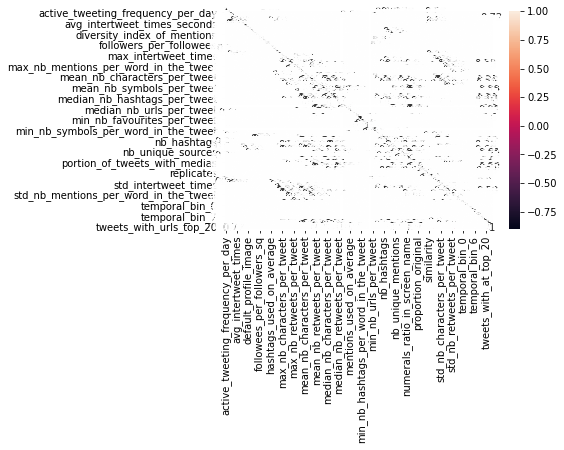

<Figure size 432x288 with 0 Axes>

In [141]:
correlation = X.corr()
import seaborn as sn 

import matplotlib.pyplot as plt
sn.heatmap(correlation, annot=True)
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig("null_values.png", dpi=300)

In [31]:

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# function for calculate the variance in data
def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

## we built the function prepare_features for making easy test with differents parametres in  the model
'''
faetures : data 
value_variance : value of the variance, if we don't want using it we make a 0 
value_centralize : if we want centralize values we can put 1, if not we make a 0 
value_PCA : dimention reduction we put the size, if we don't want using it we make 0
'''
def prepare_features(features,value_variance,value_centralize,value_PCA ):
    X_pr = features
    if (value_variance != 0):
        #add variance
        X_pr = variance_threshold_selector(X,value_variance)
        print(" dimension afer variance ",X_pr.shape)
   
    if (value_centralize != 0):
        #centralize value
        st = StandardScaler()
        X_pr = st.fit_transform(X)
    
    if (value_PCA != 0):
        # Dimention reduction
        pca = PCA(value_PCA)
        X_pr = pca.fit_transform(X)
        
    return X_pr
                
#prepare_features(features,value_variance,value_centralize,value_PCA )  
# we prepared our data with using centralization of data and dimention reduction with size = 60
new_x = prepare_features(X, 0 , 1, 60)
new_x

# create balance with data points
from imblearn.over_sampling import SMOTE,ADASYN
sm=SMOTE()
new_x,Y=sm.fit_resample(new_x,Y)
new_x

array([[ 1.29929414e+07, -1.61090845e+05,  3.39437087e+06, ...,
         3.66215797e+00,  3.11226143e+00, -3.35654584e+00],
       [-2.38992268e+06, -2.15325671e+05, -2.84498576e+04, ...,
        -1.06027392e+00,  5.97959527e+00, -1.27092171e+00],
       [ 5.58935462e+07,  4.42658965e+04,  1.50224536e+06, ...,
         3.40639534e+00, -6.85799785e+00,  4.13405746e+00],
       ...,
       [ 1.62540016e+07, -1.35813550e+05,  2.41057049e+05, ...,
        -4.84787527e+00, -1.22721478e+00, -5.09925052e-01],
       [-1.76333617e+06, -2.19501070e+05,  4.60965899e+03, ...,
         3.93675321e+00, -1.28181802e+00, -1.26998595e+00],
       [ 4.57139985e+07,  9.04620710e+03, -1.06130497e+06, ...,
        -5.52833339e+00,  1.51903100e+00, -1.53574918e-01]])

## evaluate with cross validation

In [32]:
import pickle
from sklearn.naive_bayes import  MultinomialNB,BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold,GroupKFold, cross_val_score

In [36]:
# function for evaluate our model using cross validation (we use 4 fold)
def cross_validation(model,x,y):  
  cv = StratifiedKFold(4)
  score=cross_val_score(model,x,y,cv=cv,scoring="recall")
  #print(f"Mean:{score.mean()}\n Std:{score.std()}\n")
  return score


In [40]:
# we test our model using 4 classifiers
warnings.filterwarnings("ignore")
Classifiers = [DecisionTreeClassifier(),XGBClassifier(),KNeighborsClassifier(3),LogisticRegression()]
str_calassifiers =['DecisionTreeClassifier','XGBClassifier','KNeighborsClassifier','LogisticRegression']
scores = []
for model in Classifiers :
    score = cross_validation(model,new_x,Y)
    #print(name)
    scores.append(score)
print('\n ####################################################################')
print("################ Results of Recall for each model #####################")
for i in range (0,4):
    print(str_calassifiers[i])
    print(scores[i])

[16:19:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:19:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:19:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:19:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [41]:
# evaluate our model using simple test split 
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, \
    accuracy_score, f1_score

X_train,X_test,Y_train,Y_test=train_test_split(new_x,Y,test_size=0.25,random_state=2563)

def evaluation(Y_test,Y_predict):
   print(' Accuracy:', round(accuracy_score(Y_test, Y_predict),4)*100,"%")
   print(' Recall:', round(recall_score(Y_test, Y_predict),2)*100,"%")
   print(' Precision:', round(precision_score(Y_test,Y_predict ),4)*100,"%")
   print(' F1 score:', round(f1_score(Y_test, Y_predict),4)*100,"%")
    
    

forest=XGBClassifier() #RandomForestClassifier()
model = forest.fit(X_train,Y_train)
pickle.dump(model, open("XGBClassifier.pickle.dat", "wb"))
Y_predict=forest.predict(X_test)
print("*******Classification avec XGBClassifierClassifier*******")
evaluation(Y_test,Y_predict)


[16:19:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
*******Classification avec XGBClassifierClassifier*******
 Accuracy: 98.59 %
 Recall: 99.0 %
 Precision: 97.95 %
 F1 score: 98.61999999999999 %


In [42]:
forest=DecisionTreeClassifier() #RandomForestClassifier()
model = forest.fit(X_train,Y_train)
pickle.dump(model, open("DecisionTreeClassifier.pickle.dat", "wb"))
Y_predict=forest.predict(X_test)
print("*******Classification avec DecisionTreeClassifier*******")
evaluation(Y_test,Y_predict)


*******Classification avec DecisionTreeClassifier*******
 Accuracy: 95.42 %
 Recall: 95.0 %
 Precision: 95.8 %
 F1 score: 95.47 %


In [43]:
forest=LogisticRegression() #RandomForestClassifier()
model = forest.fit(X_train,Y_train)
pickle.dump(model, open("LogisticRegression.pickle.dat", "wb"))
Y_predict=forest.predict(X_test)
print("*******Classification avec LogisticRegression*******")
evaluation(Y_test,Y_predict)


*******Classification avec LogisticRegression*******
 Accuracy: 73.24000000000001 %
 Recall: 98.0 %
 Precision: 65.89 %
 F1 score: 78.77 %


In [53]:
forest=KNeighborsClassifier(3) #RandomForestClassifier()
model = forest.fit(X_train,Y_train)
pickle.dump(model, open("Kneighbors.pickle.dat", "wb"))
Y_predict=forest.predict(X_test)
print("*******Classification avec Kneighbors*******")
evaluation(Y_test,Y_predict)

*******Classification avec Kneighbors*******
 Accuracy: 91.2 %
 Recall: 97.0 %
 Precision: 86.96000000000001 %
 F1 score: 91.8 %


In [213]:
str_calassifiers

['DecisionTreeClassifier',
 'XGBClassifier',
 'KNeighborsClassifier',
 'LogisticRegression']

In [214]:
scores

[array([0.95774648, 0.97887324, 0.97183099, 0.93661972]),
 array([0.98591549, 1.        , 1.        , 0.98591549]),
 array([0.97887324, 0.92253521, 0.95070423, 0.96478873]),
 array([0.9084507 , 0.97887324, 0.97887324, 0.99295775])]

In [215]:
scores[0]

array([0.95774648, 0.97887324, 0.97183099, 0.93661972])

In [216]:
flods = ["Fold1","Fold2","Fold3","Fold4"]

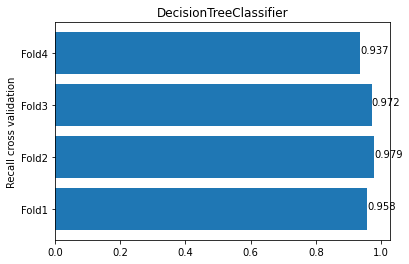

In [223]:
# results and comparison with charts 
x = flods
y = scores[0]
plt.barh(x, y)
plt.ylabel('Recall cross validation')
plt.title('DecisionTreeClassifier')
for index, value in enumerate(y):
    plt.text(round(value,3), index, str(round(value,3)))
plt.savefig("DecisionTreeClassifier.png")

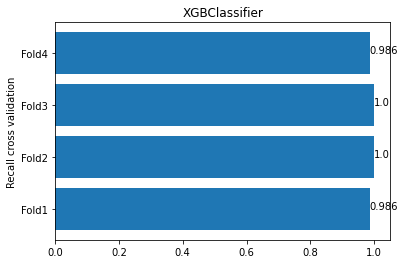

In [224]:
x = flods
y = scores[1]
plt.barh(x, y)
plt.ylabel('Recall cross validation')
plt.title('XGBClassifier')
for index, value in enumerate(y):
    plt.text(round(value,3), index, str(round(value,3)))
plt.savefig("XGBClassifier.png")

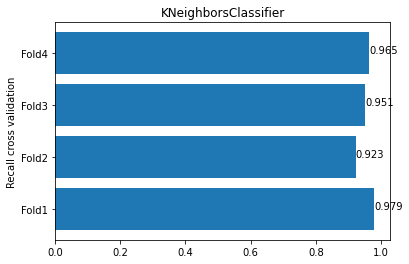

In [225]:
x = flods
y = scores[2]
plt.barh(x, y)
plt.ylabel('Recall cross validation')
plt.title('KNeighborsClassifier')
for index, value in enumerate(y):
    plt.text(round(value,3), index, str(round(value,3)))
plt.savefig("KNeighborsClassifier.png")

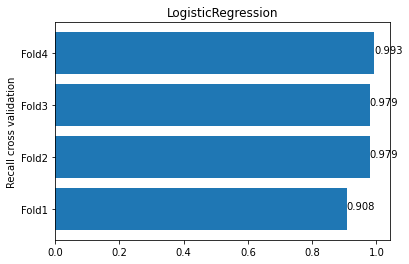

In [226]:
x = flods
y = scores[3]
plt.barh(x, y)
plt.ylabel('Recall cross validation')
plt.title('LogisticRegression')
for index, value in enumerate(y):
    plt.text(round(value,3), index, str(round(value,3)))
plt.savefig("LogisticRegression.png")

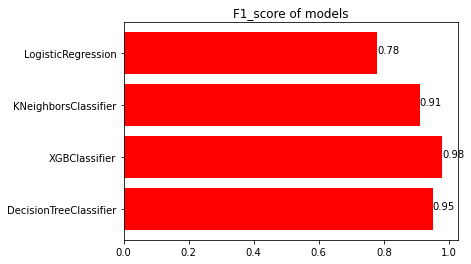

In [59]:
F1_score = [0.95,0.98,0.91,0.78]
Recall = [0.95,0.99,0.97,0.98]

x = str_calassifiers
y = F1_score
plt.barh(x, y, color ='r')
plt.ylabel('')
plt.title('F1_score of models')
for index, value in enumerate(y):
    plt.text(round(value,3), index, str(round(value,3)))
plt.savefig("f1_score.png")

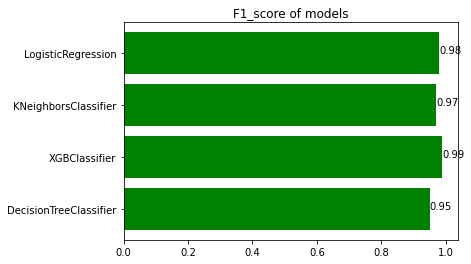

In [58]:
x = str_calassifiers
y = Recall
plt.barh(x, y, color ='g')
plt.ylabel('')
plt.title('F1_score of models')
for index, value in enumerate(y):
    plt.text(round(value,3), index, str(round(value,3)))
plt.savefig("recal_test_split.png")

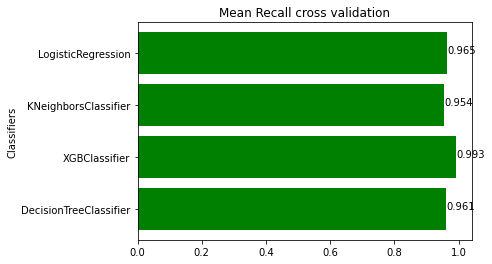

In [9]:
# Mean Recall cross validation
import matplotlib.pyplot as plt
x = str_calassifiers
y = [scores[0].mean(),scores[1].mean(),scores[2].mean(),scores[3].mean()]
plt.barh(x, y, color ='g')
plt.ylabel('Classifiers')
plt.title('Mean Recall cross validation')
for index, value in enumerate(y):
    plt.text(round(value,3), index, str(round(value,3)))
plt.savefig("classifiersMean.png")

## prediction 

In [4]:
# submission file
test_submission.head()

,coded_id,label
0,5,NaN
1,26,NaN
2,37,NaN
3,40,NaN
4,52,NaN


In [47]:
# merging features and users for predict
users_features_test = pd.merge(users_features, test_submission, on='coded_id')
users_features_test

,active_tweeting_frequency_per_day,adjusted_nb_of_uses_of_hashtag,adjusted_nb_of_uses_of_mention,adjusted_nb_of_uses_of_sources,adjusted_nb_of_uses_of_url,age,avg_intertweet_times,avg_intertweet_times_seconds,content_duration_days,date_newest_tweet,...,time_zone,tweeting_frequency_per_day,tweets_with_at_top_20,tweets_with_hashtags_top_20,tweets_with_urls_top_20,urls_used_on_average,user_id,utc_offset,coded_id,label
0,154.333,3.447,13.164,463.000,1.045,1286,0 days 00:10:33.400433000,633.0,3,27/12/2014 22:46:34,...,NaN,11.567,13,6,1,1.023,2708449765,NaN,112,NaN
1,44.222,3.335,5.005,398.000,1.000,2340,0 days 00:35:48.463476000,2148.0,9,10/02/2018 16:57:28,...,NaN,25.488,20,8,4,1.000,374254991,NaN,166,NaN
2,0.769,0.000,1.000,394.045,56.549,605,1 days 07:19:15.696742000,112756.0,520,26/01/2018 04:25:49,...,NaN,0.947,2,0,19,44.333,743321215020867589,NaN,236,NaN
3,398.000,1.074,136.909,304.653,4.750,1454,0 days 00:04:43.584383000,284.0,1,27/01/2015 22:52:50,...,NaN,2.248,11,1,0,2.667,2349365743,NaN,65,NaN
4,0.851,0.000,0.000,400.000,1.000,975,1 days 04:19:49.699248000,101990.0,470,10/02/2018 15:18:17,...,NaN,1.281,0,0,20,1.000,3318937301,NaN,152,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,40.000,3.727,9.990,116.550,2.956,3304,0 days 00:42:41.145729000,2561.0,5,25/10/2017 08:00:51,...,London,17.357,9,0,17,1.926,16683666,3600.0,595,NaN
77,9.524,6.479,9.538,114.900,1.383,3019,0 days 02:36:16.251256000,9376.0,21,25/10/2017 10:25:05,...,London,1.961,19,9,6,1.160,59079741,3600.0,696,NaN
78,3.226,0.000,0.000,200.000,0.000,3435,0 days 07:34:09.894472000,27250.0,62,20/10/2017 10:11:01,...,Brasilia,0.948,0,0,0,0.000,14972558,-7200.0,397,NaN
79,22.222,1.000,5.633,115.890,1.000,3817,0 days 01:07:23.984925000,4044.0,9,25/10/2017 01:47:33,...,Eastern Time (US & Canada),6.584,15,0,0,1.000,6091632,-14400.0,584,NaN


In [6]:
users_features_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81 entries, 0 to 80
Columns: 147 entries, active_tweeting_frequency_per_day to label
dtypes: bool(2), float64(94), int64(43), object(8)
memory usage: 92.5+ KB


In [7]:
# column content null values
df1 = users_features_test.iloc[0:0,]
columns = list(df1)
xx=[]
yy=[]
for col in columns :
    s = users_features_test[col].isna().sum()
    if (s != 0):
        print (col)
        xx.append(col)
        print(s)
        yy.append(s)
    else:
        pass
users_features_test.shape

spam_in_screen_name
81
time_zone
17
utc_offset
17
label
81


(81, 147)

In [48]:
#so we can delete this column spam_in_screen_name
users_test = users_features_test.drop(['spam_in_screen_name'], axis=1)

In [10]:

for feature in ['time_zone']:           ##List of Categorical Features
    impute_nan(users_test,feature)

for feature in ['utc_offset']:           ##List of Categorical Features
    impute_nan(users_test,feature)

users_test[['time_zone','utc_offset']].head(8)

,time_zone,utc_offset
0,Eastern Time (US & Canada),-14400.0
1,Eastern Time (US & Canada),-14400.0
2,Eastern Time (US & Canada),-14400.0
3,Eastern Time (US & Canada),-14400.0
4,Eastern Time (US & Canada),-14400.0
5,Eastern Time (US & Canada),-14400.0
6,Eastern Time (US & Canada),-14400.0
7,Eastern Time (US & Canada),-14400.0


In [50]:
# types of columns
# types of columns
columns = list(users_test.iloc[0:0,])
float_columns = []
int_columns = []
boolean_columns = []
else_columns = []
object_columns = []
for i in columns :
    #print (users_test[i].head(5))
    if users_test[i].dtype == 'float64':
        float_columns.append(i)
        #print (users_test[i].dtype)
    if users_test[i].dtype == 'int64':
        int_columns.append(i)
        #print (users_test[i].dtype)
    if users_test[i].dtype == 'bool':
        boolean_columns.append(i)
        #print (users_test[i].dtype)
    if users_test[i].dtype == 'object':
        object_columns.append(i)
        #print (users_test[i].dtype)
    else :
        else_columns.append(i)
        #print (users_test[i].dtype)

In [14]:
def delete_columns (data,liste_columns) :
    return(data.drop(liste_columns, axis=1))
users_predict = users_test
users_test=delete_columns(users_test,['user_id','coded_id','utc_offset'])  
users_test.head()

,active_tweeting_frequency_per_day,adjusted_nb_of_uses_of_hashtag,adjusted_nb_of_uses_of_mention,adjusted_nb_of_uses_of_sources,adjusted_nb_of_uses_of_url,age,avg_intertweet_times,avg_intertweet_times_seconds,content_duration_days,date_newest_tweet,...,temporal_bin_7,time_since_newest_tweet_days,time_since_newest_tweet_months,time_zone,tweeting_frequency_per_day,tweets_with_at_top_20,tweets_with_hashtags_top_20,tweets_with_urls_top_20,urls_used_on_average,label
0,154.333,3.447,13.164,463.000,1.045,1286,0 days 00:10:33.400433000,633.0,3,27/12/2014 22:46:34,...,0.162,1141,38.033333,Eastern Time (US & Canada),11.567,13,6,1,1.023,NaN
1,44.222,3.335,5.005,398.000,1.000,2340,0 days 00:35:48.463476000,2148.0,9,10/02/2018 16:57:28,...,0.055,0,0.000000,Eastern Time (US & Canada),25.488,20,8,4,1.000,NaN
2,0.769,0.000,1.000,394.045,56.549,605,1 days 07:19:15.696742000,112756.0,520,26/01/2018 04:25:49,...,0.125,16,0.533333,Eastern Time (US & Canada),0.947,2,0,19,44.333,NaN
3,398.000,1.074,136.909,304.653,4.750,1454,0 days 00:04:43.584383000,284.0,1,27/01/2015 22:52:50,...,0.141,1110,37.000000,Eastern Time (US & Canada),2.248,11,1,0,2.667,NaN
4,0.851,0.000,0.000,400.000,1.000,975,1 days 04:19:49.699248000,101990.0,470,10/02/2018 15:18:17,...,0.013,0,0.000000,Eastern Time (US & Canada),1.281,0,0,20,1.000,NaN


In [15]:
# features
X = users_test.iloc[:,0:142]
X

,active_tweeting_frequency_per_day,adjusted_nb_of_uses_of_hashtag,adjusted_nb_of_uses_of_mention,adjusted_nb_of_uses_of_sources,adjusted_nb_of_uses_of_url,age,avg_intertweet_times,avg_intertweet_times_seconds,content_duration_days,date_newest_tweet,...,temporal_bin_6,temporal_bin_7,time_since_newest_tweet_days,time_since_newest_tweet_months,time_zone,tweeting_frequency_per_day,tweets_with_at_top_20,tweets_with_hashtags_top_20,tweets_with_urls_top_20,urls_used_on_average
0,154.333,3.447,13.164,463.000,1.045,1286,0 days 00:10:33.400433000,633.0,3,27/12/2014 22:46:34,...,0.205,0.162,1141,38.033333,Eastern Time (US & Canada),11.567,13,6,1,1.023
1,44.222,3.335,5.005,398.000,1.000,2340,0 days 00:35:48.463476000,2148.0,9,10/02/2018 16:57:28,...,0.216,0.055,0,0.000000,Eastern Time (US & Canada),25.488,20,8,4,1.000
2,0.769,0.000,1.000,394.045,56.549,605,1 days 07:19:15.696742000,112756.0,520,26/01/2018 04:25:49,...,0.142,0.125,16,0.533333,Eastern Time (US & Canada),0.947,2,0,19,44.333
3,398.000,1.074,136.909,304.653,4.750,1454,0 days 00:04:43.584383000,284.0,1,27/01/2015 22:52:50,...,0.209,0.141,1110,37.000000,Eastern Time (US & Canada),2.248,11,1,0,2.667
4,0.851,0.000,0.000,400.000,1.000,975,1 days 04:19:49.699248000,101990.0,470,10/02/2018 15:18:17,...,0.065,0.013,0,0.000000,Eastern Time (US & Canada),1.281,0,0,20,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,40.000,3.727,9.990,116.550,2.956,3304,0 days 00:42:41.145729000,2561.0,5,25/10/2017 08:00:51,...,0.040,0.000,2,0.066667,London,17.357,9,0,17,1.926
77,9.524,6.479,9.538,114.900,1.383,3019,0 days 02:36:16.251256000,9376.0,21,25/10/2017 10:25:05,...,0.135,0.075,2,0.066667,London,1.961,19,9,6,1.160
78,3.226,0.000,0.000,200.000,0.000,3435,0 days 07:34:09.894472000,27250.0,62,20/10/2017 10:11:01,...,0.200,0.005,7,0.233333,Brasilia,0.948,0,0,0,0.000
79,22.222,1.000,5.633,115.890,1.000,3817,0 days 01:07:23.984925000,4044.0,9,25/10/2017 01:47:33,...,0.265,0.270,2,0.066667,Eastern Time (US & Canada),6.584,15,0,0,1.000


In [44]:
# types of columns
columns = list(X.iloc[0:0,])
float_columns = []
int_columns = []
boolean_columns = []
else_columns = []
object_columns = []
for i in columns :
    #print (X[i].head(5))
    if X[i].dtype == 'float64':
        float_columns.append(i)
        #print (X[i].dtype)
    if X[i].dtype == 'int64':
        int_columns.append(i)
        #print (X[i].dtype)
    if X[i].dtype == 'bool':
        boolean_columns.append(i)
        #print (X[i].dtype)
    if X[i].dtype == 'object':
        object_columns.append(i)
        #print (X[i].dtype)
    else :
        else_columns.append(i)
        #print (X[i].dtype)

In [17]:
X.head()

,active_tweeting_frequency_per_day,adjusted_nb_of_uses_of_hashtag,adjusted_nb_of_uses_of_mention,adjusted_nb_of_uses_of_sources,adjusted_nb_of_uses_of_url,age,avg_intertweet_times,avg_intertweet_times_seconds,content_duration_days,date_newest_tweet,...,temporal_bin_6,temporal_bin_7,time_since_newest_tweet_days,time_since_newest_tweet_months,time_zone,tweeting_frequency_per_day,tweets_with_at_top_20,tweets_with_hashtags_top_20,tweets_with_urls_top_20,urls_used_on_average
0,154.333,3.447,13.164,463.000,1.045,1286,0 days 00:10:33.400433000,633.0,3,27/12/2014 22:46:34,...,0.205,0.162,1141,38.033333,Eastern Time (US & Canada),11.567,13,6,1,1.023
1,44.222,3.335,5.005,398.000,1.000,2340,0 days 00:35:48.463476000,2148.0,9,10/02/2018 16:57:28,...,0.216,0.055,0,0.000000,Eastern Time (US & Canada),25.488,20,8,4,1.000
2,0.769,0.000,1.000,394.045,56.549,605,1 days 07:19:15.696742000,112756.0,520,26/01/2018 04:25:49,...,0.142,0.125,16,0.533333,Eastern Time (US & Canada),0.947,2,0,19,44.333
3,398.000,1.074,136.909,304.653,4.750,1454,0 days 00:04:43.584383000,284.0,1,27/01/2015 22:52:50,...,0.209,0.141,1110,37.000000,Eastern Time (US & Canada),2.248,11,1,0,2.667
4,0.851,0.000,0.000,400.000,1.000,975,1 days 04:19:49.699248000,101990.0,470,10/02/2018 15:18:17,...,0.065,0.013,0,0.000000,Eastern Time (US & Canada),1.281,0,0,20,1.000


In [18]:
from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()
categorical_cols = boolean_columns + object_columns
# apply le on categorical feature columns
X[categorical_cols] = X[categorical_cols].apply(lambda col: labelencoder.fit_transform(col))
X[categorical_cols]

,default_profile,default_profile_image,avg_intertweet_times,date_newest_tweet,date_oldest_tweet,lang,max_intertweet_times,min_intertweet_times,std_intertweet_times,time_zone
0,1,0,8,76,72,3,5,3,5,8
1,1,0,13,14,79,3,36,0,19,8
2,1,0,76,74,64,3,65,5,73,8
3,1,0,2,75,73,3,0,2,0,8
4,1,0,75,11,77,3,71,19,60,8
...,...,...,...,...,...,...,...,...,...,...
76,0,0,15,62,53,3,19,0,16,13
77,0,0,45,64,6,3,44,2,43,13
78,0,0,60,19,44,6,75,18,62,4
79,0,0,24,40,34,3,30,0,28,8


In [19]:
# label
Y = users_test.iloc[:,142]
Y.head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: label, dtype: float64

In [20]:
#prepare_features(features,value_variance,value_centralize,value_PCA )   

new_x = prepare_features(X, 0 , 1, 60)
new_x


array([[-2.22244972e+06, -2.61369056e+05,  3.96345789e+04, ...,
        -2.75557584e-01, -1.59683424e+00, -1.04089237e+00],
       [-2.15562982e+06, -2.59128070e+05,  3.91488310e+04, ...,
         7.79726170e-01, -1.52004686e+00, -2.23830365e+00],
       [ 3.16109834e+07,  1.79087869e+04, -1.96302644e+06, ...,
        -1.97887723e-01,  7.99316050e-02, -3.01724383e-01],
       ...,
       [-1.67521607e+06,  1.33107171e+05,  3.40626022e+04, ...,
        -3.22232951e-01,  5.77581229e-02, -9.39862066e-03],
       [-2.16068898e+06, -2.22466888e+05,  4.28466699e+04, ...,
         7.38468128e-01, -3.02692805e-01, -2.17873243e+00],
       [-2.21174050e+06, -2.27907079e+05,  3.71744611e+04, ...,
         2.85585829e+00,  2.02947063e+00, -7.51327640e-01]])

In [21]:
# load model from file
import pickle
import pandas as pd
loaded_model = pickle.load(open("./models/XGBClassifier.pickle.dat", "rb"))
loaded_model2 = pickle.load(open("./models/DecisionTreeClassifier.pickle.dat", "rb"))
loaded_model3 = pickle.load(open("./models/LogisticRegression.pickle.dat", "rb"))

# make predictions for test data with three classifiers
y_pred = loaded_model.predict(new_x)
print(y_pred)
y_pred2 = loaded_model2.predict(new_x)
print(y_pred2)
y_pred3 = loaded_model3.predict(new_x)
print(y_pred3)

[0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1]
[1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1
 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 1 0 0 0 1]
[1 0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1
 0 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 0 1 1 0
 0 1 1 1 1 1 1]


In [37]:
y_pred2

array([1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1], dtype=int64)

In [35]:
# last submission file
users_predict["label"] = y_pred
users_predict [['coded_id','label']]
ordoned = users_predict [['coded_id','label']].sort_values(by=['coded_id'])
ordoned.to_csv('./results_test/test_XGB.csv',index=False)
ordoned

,coded_id,label
24,5,0
13,26,0
14,37,0
12,40,0
7,52,1
...,...,...
73,729,0
42,745,0
72,746,0
70,757,0


In [40]:
users_predict["label"] = y_pred2
users_predict [['coded_id','label']]
users_predict [['coded_id','label']]
ordoned = users_predict [['coded_id','label']].sort_values(by=['coded_id'])
ordoned.to_csv('./results_test/test_DT.csv',index=False)
ordoned

,coded_id,label
24,5,0
13,26,0
14,37,1
12,40,0
7,52,0
...,...,...
73,729,0
42,745,1
72,746,0
70,757,1


In [22]:

merged_predect_XGB = users_predict
merged_predect_XGB["label"] = y_pred

merged_predect_DTree = users_predict
merged_predect_DTree["label"] = y_pred2

merged_predect_LR = users_predict
merged_predect_LR["label"] = y_pred3

submited_test = merged_predect_LR [['coded_id','label']]
merged_predect_XGB   

,active_tweeting_frequency_per_day,adjusted_nb_of_uses_of_hashtag,adjusted_nb_of_uses_of_mention,adjusted_nb_of_uses_of_sources,adjusted_nb_of_uses_of_url,age,avg_intertweet_times,avg_intertweet_times_seconds,content_duration_days,date_newest_tweet,...,time_zone,tweeting_frequency_per_day,tweets_with_at_top_20,tweets_with_hashtags_top_20,tweets_with_urls_top_20,urls_used_on_average,user_id,utc_offset,coded_id,label
0,154.333,3.447,13.164,463.000,1.045,1286,0 days 00:10:33.400433000,633.0,3,27/12/2014 22:46:34,...,Eastern Time (US & Canada),11.567,13,6,1,1.023,2708449765,-14400.0,112,1
1,44.222,3.335,5.005,398.000,1.000,2340,0 days 00:35:48.463476000,2148.0,9,10/02/2018 16:57:28,...,Eastern Time (US & Canada),25.488,20,8,4,1.000,374254991,-14400.0,166,0
2,0.769,0.000,1.000,394.045,56.549,605,1 days 07:19:15.696742000,112756.0,520,26/01/2018 04:25:49,...,Eastern Time (US & Canada),0.947,2,0,19,44.333,743321215020867589,-14400.0,236,1
3,398.000,1.074,136.909,304.653,4.750,1454,0 days 00:04:43.584383000,284.0,1,27/01/2015 22:52:50,...,Eastern Time (US & Canada),2.248,11,1,0,2.667,2349365743,-14400.0,65,1
4,0.851,0.000,0.000,400.000,1.000,975,1 days 04:19:49.699248000,101990.0,470,10/02/2018 15:18:17,...,Eastern Time (US & Canada),1.281,0,0,20,1.000,3318937301,-14400.0,152,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,40.000,3.727,9.990,116.550,2.956,3304,0 days 00:42:41.145729000,2561.0,5,25/10/2017 08:00:51,...,London,17.357,9,0,17,1.926,16683666,3600.0,595,1
77,9.524,6.479,9.538,114.900,1.383,3019,0 days 02:36:16.251256000,9376.0,21,25/10/2017 10:25:05,...,London,1.961,19,9,6,1.160,59079741,3600.0,696,1
78,3.226,0.000,0.000,200.000,0.000,3435,0 days 07:34:09.894472000,27250.0,62,20/10/2017 10:11:01,...,Brasilia,0.948,0,0,0,0.000,14972558,-7200.0,397,1
79,22.222,1.000,5.633,115.890,1.000,3817,0 days 01:07:23.984925000,4044.0,9,25/10/2017 01:47:33,...,Eastern Time (US & Canada),6.584,15,0,0,1.000,6091632,-14400.0,584,1
